In [504]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
import matplotlib.cm as cm
#from IPython.display import JSON
import math
import inspect
from typing import List, Dict, Optional

In [505]:
def show_df_info(df: pd.DataFrame) -> pd.DataFrame:
    """
    Prints information about a DataFrame, including column names, data types, and non-null counts.
    
    Args:
        df (pandas.DataFrame): The DataFrame to process.
        
    Returns:
        pandas.DataFrame: A DataFrame containing the column names, data types, and non-null counts, and null counts of the input DataFrame.
    """
    col_names = df.columns.to_list()
    col_dtypes = df.dtypes.to_list()
    non_null_counts = df.count().to_list()
    null_counts = df.isnull().sum().to_list()
    info_df = pd.DataFrame({'column_name': col_names, 'dtype': col_dtypes, 'non_null_count': non_null_counts, 'null_count': null_counts})

    caller_frame = inspect.currentframe().f_back
    df_name = [var_name for var_name, var_val in caller_frame.f_locals.items() if var_val is df][0]

    print(f"DataFrame '{df_name}' has {len(df)} rows and {len(df.columns)} columns.")
    print("Here is a summary of the column names, data types and null counts:")
    return info_df

In [506]:
def get_unique_links(df):
    #unique_links = df['link'].unique()
    unique_links = df['link'].unique().tolist()
    return unique_links

In [507]:
def get_nonunique_links(df):
    #nonunique_links = df[df.duplicated(['link'])]
    #nonunique_links = df[df.duplicated(['link'])]['link']
    nonunique_links = df[df.duplicated(['link'])]['link'].tolist()
    return nonunique_links

In [508]:
def multiplotv_dark(df: pd.DataFrame, filter_col: str = None, fmin: float = None, fmax: float = None) -> None:
    """
    Generate a set of 4 plots to visualize the relationship between two variables in a DataFrame.
    :param df: DataFrame containing the data
    :param filter_col: Name of the column to filter on (optional)
    :param filter_min: Minimum value for the filter_col (optional)
    :param filter_max: Maximum value for the filter_col (optional)
    """

    # define subplots
    face_color = '0.1'
    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(16, 12), facecolor=face_color)
    
    # Set background color to black
    #plt.style.use('dark_background')

    # apply filter and subtitle
    if filter_col:
        if fmin is not None and fmax is not None:
            if fmin < fmax:
                fig.text(0.5, 0.94, f'Filtered on {fmin} < {filter_col} < {fmax}', ha='center', fontsize=16, color='white')
                df = df[(df[filter_col] <= fmax) & (df[filter_col] >= fmin)]
            else:
                fmin, fmax = fmax, fmin
                fig.text(0.5, 0.94, f'Filtered on {fmin} > {filter_col} > {fmax}', ha='center', fontsize=16, color='white')
                df = df[(df[filter_col] >= fmax) | (df[filter_col] <= fmin)]
        elif fmin is not None and fmax is None:
            fig.text(0.5, 0.94, f'Filtered on {filter_col} > {fmin}', ha='center', fontsize=16, color='white')
            df = df[df[filter_col] >= fmin]
        elif fmin is None and fmax is not None:
            fig.text(0.5, 0.94, f'Filtered on {filter_col} < {fmax}', ha='center', fontsize=16, color='white')
            df = df[df[filter_col] <= fmax]
        else:
            print(f'Warning: you must provide a min and/or max on which to filter on {filter_col} or no filtering will occur')

    # apply main title
    main_title = f'Correlation Study: Rank vs Percent Human ({len(df)} data points)'
    fig.suptitle(main_title, fontsize=20, fontweight='bold', y=.98, color='white')
    
    
    # Fig 1: Q-Q plot [0, 0]
    st.probplot(df['percent_human'], dist='norm', plot=axs[0, 0])
    axs[0, 0].set_title('Figure 1: Q-Q Plot of Percent Human')
    axs[0, 0].set_xlabel('Theoretical quantiles')
    axs[0, 0].set_ylabel('Sample quantiles')
    axs[0, 0].text(0.02, 0.95, 'Data is not normally distributed\nand cannot be evaluated using Pearson\'s method', transform=axs[0, 0].transAxes, fontsize=12, verticalalignment='top', color='white')

    
    # Fig 2: Histogram [0, 1]
    sns.histplot(data=df['percent_human'], kde=False, binwidth=1, color='green', ax=axs[0, 1], edgecolor='grey')
    axs[0, 1].set_title('Figure 2: Histogram of Percent Human')
    axs[0, 1].set_xlabel('Percent Human')
    axs[0, 1].set_ylabel('Count')
    axs[0, 1].set_xlim(-5, 105)
    axs[0, 1].set_ylim(0, None)
    skewness = round(st.skew(df['percent_human']), 2)
    axs[0, 1].text(0.02, 0.95, f'Data Skewness {skewness}', transform=axs[0, 1].transAxes, fontsize=12, verticalalignment='top', color='white')
    #axs[0, 1].text(0.02, 0.90, f'Over 1/3 of data in top 2%', transform=axs[0, 1].transAxes, fontsize=12, verticalalignment='top', color='black')

    
    # Fig 3: Violin plot [1, 0]
    sns.violinplot(ax=axs[1, 0], data=df, x="rank", y="percent_human", scale="count", inner="box", color="#00aa00", saturation=0.5, cut=0, linewidth=.9)

        # plot mean lines
    for i, mean in enumerate(df.groupby("rank")["percent_human"].mean()):
        axs[1, 0].hlines(mean, i-0.25, i+0.25, linewidth=1, color='#bbbbbb', zorder=100)

        # plot median markers
    median_markers = df.groupby('rank')['percent_human'].median()
    sns.scatterplot(ax=axs[1, 0], x=median_markers.index-1, y=median_markers.values, marker='o', s=20, color='white', edgecolor='black', zorder=100)
    
    axs[1, 0].set_title('Figure 3: Percent Human vs Rank')
    axs[1, 0].set_xlabel('Rank')
    axs[1, 0].set_ylabel('Percent Human')

   
    # Fig 4: Scatter plot [1, 1]
    grouped_data = df.groupby('rank')
    mean_percent_human = grouped_data['percent_human'].mean().reset_index()
    sns.scatterplot(ax=axs[1, 1], data=mean_percent_human, x='rank', y='percent_human',  color='green', edgecolor=None)
    sns.regplot(ax=axs[1, 1], data=mean_percent_human, x='rank', y='percent_human', color='green', scatter=False, line_kws={'linestyle':'--'})
    axs[1, 1].set_title('Figure 4: Mean Percent Human vs Rank')
    axs[1, 1].set_xlabel('Rank')
    axs[1, 1].set_ylabel('Mean Percent Human')
    axs[1, 1].set_xticks(np.arange(1, 21))
    axs[1, 1].legend(handles=axs[1, 1].lines[::len(mean_percent_human)], labels=['Best fit line'], facecolor=face_color, labelcolor='white')
    axs[1, 1].text(0.02, 0.05, f'Percent Human is weakly correlated to Rank with a high degree of certainty', transform=axs[1, 1].transAxes, fontsize=10, verticalalignment='top', color='white')

        # Calculate correlation coefficients and p-values
    pb_corr, pb_pval = st.pointbiserialr(df['rank'], df['percent_human'])
    spearman_corr, spearman_pval = st.spearmanr(df['rank'], df['percent_human'])
    kendall_tau, kendall_pval = st.kendalltau(df['rank'], df['percent_human'])

        # Create a dictionary to store the results
    corr = {
        'Method': ['Point Biserial', 'Spearman', 'Kendall'],
        'Corr Coef': [pb_corr, spearman_corr, kendall_tau],
        'P-value': [pb_pval, spearman_pval, kendall_pval]
    }

        # Create a pandas dataframe from the corr dict
    df_corr = pd.DataFrame(corr)

        # Create a table to display the correlation coefficients and p-values
    table_data = [list(df_corr.columns)] + df_corr.values.tolist()
    table = axs[1, 1].table(cellText=table_data,
                    colLabels=None,
                    cellLoc='center',
                    bbox=[0.02, 0.08, 0.5, 0.15],  # x, y, width, height
                    cellColours=[[face_color]*3] + [[face_color]*3]*len(df_corr))
    table.set_fontsize(10)
    for cell in table.get_celld().values():
        cell.set_linewidth(0)
        cell.set_edgecolor('none')
        cell.set_text_props(color='white')


        # Format the table to use 4 significant figures
    for i in range(1, len(table_data)):
        for j in range(1, 3):
            cell = table.get_celld()[i, j]
            cell_text = cell.get_text().get_text()
            cell_text = float(cell_text)
            cell_text = f'{cell_text:.4g}'
            cell.get_text().set_text(cell_text)
            #cell.set_edgecolor('white')
    
    font_color = '#cccccc'
    for ax in axs.flat:
        ax.tick_params(axis='x', labelsize=12, colors=font_color)
        ax.tick_params(axis='y', labelsize=12, colors=font_color)
        ax.set_xlabel(ax.get_xlabel(), fontdict={'fontsize': 14, 'color': font_color})
        ax.set_ylabel(ax.get_xlabel(), fontdict={'fontsize': 14, 'color': font_color})
        ax.set_title(ax.get_title(), fontdict={'fontsize': 16, 'color': 'white'})
        ax.set_facecolor(face_color)
        for spine in ax.spines.values():
            spine.set_edgecolor('white')
            #spine.set_linewidth(2)
    
    # shrink outer margin
    fig.subplots_adjust(left=0.05, right=0.95, top=.90, bottom=0.05)
   
    fig.savefig('figures/Fig_1-4.png')
    plt.show()

In [509]:
def get_highest_kw_per_link(df, links):
    highest_kw_per_link = list()
    for link in links:
        # Select rows with the given link
        link_df = df[df['link'] == link]
        # Count the number of occurrences of each 'kw' value
        kw_counts = link_df['kw'].value_counts()
        # Get the highest 'kw' value, or None if there are no 'kw' values
        highest_kw = kw_counts.index[0] if len(kw_counts) > 0 else None
        # Append the highest 'kw' value for this link to the output list
        highest_kw_per_link.append(highest_kw)
    return highest_kw_per_link

In [510]:
df = pd.read_csv('data/data_clean.old.csv')
df.head(1)

,kw,rank,link,success,word_count,percent_human,percent_ai
0,how to finish concrete,1,https://www.familyhandyman.com/project/how-to-...,True,1689.0,99.926081,0.073917


In [511]:
len(df)

14637

In [512]:
#df['uid'] = df['kw'] + '*' + df['link']
#df['uid'] = df.apply(lambda row: f"{row['kw']}_{row['link']}", axis=1)
#df['uid'] = df.apply(lambda row: f"{row['kw']}_{row['rank']}_{row['link']}", axis=1)
df['uid'] = df.apply(lambda row: f"{row['kw']}_{row['link']}", axis=1)
df['uid'] = df['uid'].str.strip()

In [513]:
df['uid'].nunique()

14371

In [514]:
result = df[df['uid'].duplicated(keep=False)]

In [515]:
result

,kw,rank,link,success,word_count,percent_human,percent_ai,uid
36,early stage blood clot in foot pictures,9,https://stock.adobe.com/search?k=blood%20clots...,True,231.0,3.062132,96.937871,early stage blood clot in foot pictures_https:...
43,early stage blood clot in foot pictures,17,https://stock.adobe.com/search?k=blood%20clots...,True,231.0,3.062132,96.937871,early stage blood clot in foot pictures_https:...
91,diastasis,15,https://www.medicalnewstoday.com/articles/dias...,True,923.0,96.124017,3.875982,diastasis_https://www.medicalnewstoday.com/art...
93,diastasis,17,https://dianeleephysio.com/education/diastasis...,True,4885.0,97.989366,2.010634,diastasis_https://dianeleephysio.com/education...
94,diastasis,18,https://www.medicalnewstoday.com/articles/dias...,True,923.0,96.124017,3.875982,diastasis_https://www.medicalnewstoday.com/art...
...,...,...,...,...,...,...,...,...
14590,bilateral pneumonia,18,https://www.cidrap.umn.edu/argentine-officials...,True,636.0,96.696997,3.303000,bilateral pneumonia_https://www.cidrap.umn.edu...
14591,bilateral pneumonia,19,https://medlineplus.gov/pneumonia.html,True,515.0,1.570927,98.429072,bilateral pneumonia_https://medlineplus.gov/pn...
14592,bilateral pneumonia,20,https://www.cidrap.umn.edu/argentine-officials...,True,636.0,96.696997,3.303000,bilateral pneumonia_https://www.cidrap.umn.edu...
14635,ruched midi dress,19,https://www.loft.com/petites/petite-dresses/ca...,True,1602.0,92.680357,7.319643,ruched midi dress_https://www.loft.com/petites...


In [516]:
df['uid'][0]

'how to finish concrete_https://www.familyhandyman.com/project/how-to-finish-concrete/'

In [517]:
df.head(1)

,kw,rank,link,success,word_count,percent_human,percent_ai,uid
0,how to finish concrete,1,https://www.familyhandyman.com/project/how-to-...,True,1689.0,99.926081,0.073917,how to finish concrete_https://www.familyhandy...


In [518]:
combined_df = pd.read_csv('data/linked_kw_finalcombined.csv', header=0)
combined_df['link'] = combined_df['url']
combined_df = combined_df.drop(['url'], axis=1)
#combined_df['uid'] = combined_df['kw'] + '*' + combined_df['link']
#combined_df['uid'] = combined_df.apply(lambda row: f"{row['kw']}_{row['rank']}_{row['link']}", axis=1)
combined_df['uid'] = combined_df.apply(lambda row: f"{row['kw']}_{row['link']}", axis=1)
#combined_df['uid'] = combined_df['uid'].astype(str)
combined_df['uid'] = combined_df['uid'].str.strip()
#combined_df = combined_df.drop(['kw'], axis=1)

In [581]:
kwf = pd.read_csv('data/linked_kw_final.csv', header=0)
len(kwf)
kwf.head()

,kw,rank,link
0,side table lamps,1,https://www.target.com/c/table-lamps-lighting-...
1,side table lamps,2,https://www.amazon.com/Side-Table-Lamps/s?k=Si...
2,side table lamps,3,https://www.wayfair.com/lighting/sb1/bedside-t...
3,side table lamps,4,https://www.ikea.com/us/en/cat/table-lamps-10732/
4,side table lamps,5,https://www.crateandbarrel.com/lighting/table-...


In [520]:
combined_df[combined_df['link']=='https://www.amazon.com/Side-Table-Lamps/s?k=Side+Table+Lamps']

,kw,SERP features,Volume,KD,CPC,Traffic,uid,url_count,link


In [521]:
df1 = pd.read_csv('data/webmd.csv')
df2 = pd.read_csv('data/thespruce.csv')
df3 = pd.read_csv('data/amazon.csv')
new = pd.concat([df1, df2, df3])
new = new.reset_index(drop=True)
new = new.copy(deep=True)
drop_columns = ['Current position', 'Current URL inside', 'Updated']
new = new.drop(drop_columns, axis=1)
new = new.rename(columns={'Current URL': 'url'})
new = new.rename(columns={'Keyword': 'kw'})
new = new.copy(deep=True)
#new['uid'] = new['kw'] + '*' + new['url']
#new['uid'] = new.apply(lambda row: f"{row['kw']}_{row['url']}", axis=1)
#new['uid'] = new.apply(lambda row: f"{row['kw']}_{row['rank']}_{row['url']}", axis=1)
new['uid'] = new.apply(lambda row: f"{row['kw']}_{row['url']}", axis=1)
new['uid'] = new['uid'].str.strip()

In [522]:
new.head(1)

,kw,SERP features,Volume,KD,CPC,Traffic,url,uid
0,horny goat weed,Knowledge panel,76000,61,0.37,70591,https://www.webmd.com/vitamins/ai/ingredientmo...,horny goat weed_https://www.webmd.com/vitamins...


In [523]:
new['uid'].nunique()

90000

In [524]:
len(new)

90000

In [525]:
show_df_info(new)

DataFrame 'new' has 90000 rows and 8 columns.
Here is a summary of the column names, data types and null counts:


,column_name,dtype,non_null_count,null_count
0,kw,object,90000,0
1,SERP features,object,89313,687
2,Volume,int64,90000,0
3,KD,int64,90000,0
4,CPC,float64,76574,13426
5,Traffic,int64,90000,0
6,url,object,90000,0
7,uid,object,90000,0


In [526]:
new.head(1)

,kw,SERP features,Volume,KD,CPC,Traffic,url,uid
0,horny goat weed,Knowledge panel,76000,61,0.37,70591,https://www.webmd.com/vitamins/ai/ingredientmo...,horny goat weed_https://www.webmd.com/vitamins...


In [527]:
new['uid'][0]

'horny goat weed_https://www.webmd.com/vitamins/ai/ingredientmono-699/horny-goat-weed'

In [528]:
new[new['url']=='https://www.amazon.com/Side-Table-Lamps/s?k=Side+Table+Lamps']

,kw,SERP features,Volume,KD,CPC,Traffic,url,uid


In [529]:
new[new['uid']=='side table lamps_https://www.target.com/c/table-lamps-lighting-home-decor/-/N-56d7t']

,kw,SERP features,Volume,KD,CPC,Traffic,url,uid


In [530]:
new[new['kw']=='side table lamps']

,kw,SERP features,Volume,KD,CPC,Traffic,url,uid
58100,side table lamps,"Image pack, Thumbnail, Shopping results, Sitel...",2100,45,1.65,16,https://www.thespruce.com/how-to-pick-a-bedsid...,side table lamps_https://www.thespruce.com/how...


In [531]:
df1 = pd.merge(left=df, right=new, on='uid', how='outer')
#df1 = pd.merge(left=df, right=combined_df, on='uid', how='outer')

In [532]:
df1.head(1)

,kw_x,rank,link,success,word_count,percent_human,percent_ai,uid,kw_y,SERP features,Volume,KD,CPC,Traffic,url
0,how to finish concrete,1.0,https://www.familyhandyman.com/project/how-to-...,True,1689.0,99.926081,0.073917,how to finish concrete_https://www.familyhandy...,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [533]:
df1.head(1)

,kw_x,rank,link,success,word_count,percent_human,percent_ai,uid,kw_y,SERP features,Volume,KD,CPC,Traffic,url
0,how to finish concrete,1.0,https://www.familyhandyman.com/project/how-to-...,True,1689.0,99.926081,0.073917,how to finish concrete_https://www.familyhandy...,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [534]:
show_df_info(df1)

DataFrame 'df1' has 103885 rows and 15 columns.
Here is a summary of the column names, data types and null counts:


,column_name,dtype,non_null_count,null_count
0,kw_x,object,14637,89248
1,rank,float64,14637,89248
2,link,object,14637,89248
3,success,object,14637,89248
4,word_count,float64,14637,89248
5,percent_human,float64,14637,89248
6,percent_ai,float64,14637,89248
7,uid,object,103885,0
8,kw_y,object,90004,13881
9,SERP features,object,89317,14568


In [535]:
#result = df1.loc[df1['kw_x'] == df1['kw_y'], ['uid', 'link_x', 'link_y', 'kw_x', 'kw_y']]
result = df1.loc[df1['kw_x'] == df1['kw_y'], ['uid', 'url', 'link', 'kw_x', 'kw_y']]

In [536]:
df1.head()

,kw_x,rank,link,success,word_count,percent_human,percent_ai,uid,kw_y,SERP features,Volume,KD,CPC,Traffic,url
0,how to finish concrete,1.0,https://www.familyhandyman.com/project/how-to-...,True,1689.0,99.926081,0.073917,how to finish concrete_https://www.familyhandy...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,how to finish concrete,4.0,https://www.wikihow.com/Finish-Concrete,True,324.0,88.443929,11.556073,how to finish concrete_https://www.wikihow.com...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,how to finish concrete,5.0,https://www.instructables.com/How-to-Finish-Co...,True,1417.0,94.222470,5.777531,how to finish concrete_https://www.instructabl...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,how to finish concrete,6.0,https://carrollsbuildingmaterials.com/diy-conc...,True,1600.0,99.730074,0.269922,how to finish concrete_https://carrollsbuildin...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,how to finish concrete,7.0,https://www.hunker.com/13402242/how-to-finish-...,True,738.0,97.359934,2.640062,how to finish concrete_https://www.hunker.com/...,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [537]:
df1['uid'][0]

'how to finish concrete_https://www.familyhandyman.com/project/how-to-finish-concrete/'

In [538]:
result.head()

,uid,url,link,kw_x,kw_y
17,saline spray for piercings_https://www.amazon....,https://www.amazon.com/H2Ocean-4oz-Piercing-Af...,https://www.amazon.com/H2Ocean-4oz-Piercing-Af...,saline spray for piercings,saline spray for piercings
30,early stage blood clot in foot pictures_https:...,https://www.webmd.com/dvt/ss/slideshow-deep-ve...,https://www.webmd.com/dvt/ss/slideshow-deep-ve...,early stage blood clot in foot pictures,early stage blood clot in foot pictures
53,coleus annual or perennial_https://www.thespru...,https://www.thespruce.com/how-to-grow-coleus-p...,https://www.thespruce.com/how-to-grow-coleus-p...,coleus annual or perennial,coleus annual or perennial
66,tub surround ideas_https://www.thespruce.com/e...,https://www.thespruce.com/examples-of-tub-surr...,https://www.thespruce.com/examples-of-tub-surr...,tub surround ideas,tub surround ideas
80,diastasis_https://www.webmd.com/baby/guide/abd...,https://www.webmd.com/baby/guide/abdominal-sep...,https://www.webmd.com/baby/guide/abdominal-sep...,diastasis,diastasis


In [539]:
def count_unique(df, col):
    count_dict = {}
    for uid in df[col].unique():
        count_dict[uid] = df[df[col] == uid][col].count()
    # sort the dictionary by value in descending order
    sorted_dict = dict(sorted(count_dict.items(), key=lambda item: item[1], reverse=True))
    return sorted_dict

In [540]:
uids = count_unique(df, 'uid')

In [541]:
#uids['trash bin*https://www.vocabulary.com/dictionary/trash%20bin']

In [542]:
len(df)

14637

In [543]:
unique_links = get_unique_links(df)
len(unique_links)

14057

In [544]:
nonunique_links = get_nonunique_links(df)
len(nonunique_links)

580

In [545]:
df_unique_links = df[~df['link'].isin(nonunique_links)]
len(df_unique_links)

13497

In [546]:
df_unique_links.head(10).sort_values(by='link')

,kw,rank,link,success,word_count,percent_human,percent_ai,uid
6,how to finish concrete,9,https://blog.onfloor.com/concrete-finishing-steps,True,957.0,99.106458,0.893543,how to finish concrete_https://blog.onfloor.co...
3,how to finish concrete,6,https://carrollsbuildingmaterials.com/diy-conc...,True,1600.0,99.730074,0.269922,how to finish concrete_https://carrollsbuildin...
8,how to finish concrete,11,https://www.archtoolbox.com/concrete-finishing...,True,1252.0,69.787031,30.212969,how to finish concrete_https://www.archtoolbox...
5,how to finish concrete,8,https://www.ehow.com/way_5571195_inexpensive-w...,True,599.0,93.625480,6.374515,how to finish concrete_https://www.ehow.com/wa...
0,how to finish concrete,1,https://www.familyhandyman.com/project/how-to-...,True,1689.0,99.926081,0.073917,how to finish concrete_https://www.familyhandy...
4,how to finish concrete,7,https://www.hunker.com/13402242/how-to-finish-...,True,738.0,97.359934,2.640062,how to finish concrete_https://www.hunker.com/...
2,how to finish concrete,5,https://www.instructables.com/How-to-Finish-Co...,True,1417.0,94.222470,5.777531,how to finish concrete_https://www.instructabl...
9,how to finish concrete,12,https://www.polishtheplanet.com/blog/article/w...,True,838.0,97.508889,2.491105,how to finish concrete_https://www.polishthepl...
7,how to finish concrete,10,https://www.protradecraft.com/how-finish-concr...,True,233.0,99.972695,0.027307,how to finish concrete_https://www.protradecra...
1,how to finish concrete,4,https://www.wikihow.com/Finish-Concrete,True,324.0,88.443929,11.556073,how to finish concrete_https://www.wikihow.com...


In [547]:
df_nonunique_links = df[df['link'].isin(nonunique_links)]
len(df_nonunique_links)


1140

In [548]:
df_nonunique_links.head(10).sort_values(by='link')

,kw,rank,link,success,word_count,percent_human,percent_ai,uid
93,diastasis,17,https://dianeleephysio.com/education/diastasis...,True,4885.0,97.989366,2.010634,diastasis_https://dianeleephysio.com/education...
95,diastasis,19,https://dianeleephysio.com/education/diastasis...,True,4885.0,97.989366,2.010634,diastasis_https://dianeleephysio.com/education...
36,early stage blood clot in foot pictures,9,https://stock.adobe.com/search?k=blood%20clots...,True,231.0,3.062132,96.937871,early stage blood clot in foot pictures_https:...
43,early stage blood clot in foot pictures,17,https://stock.adobe.com/search?k=blood%20clots...,True,231.0,3.062132,96.937871,early stage blood clot in foot pictures_https:...
39,early stage blood clot in foot pictures,13,https://www.mayoclinic.org/diseases-conditions...,True,1172.0,68.960370,31.039628,early stage blood clot in foot pictures_https:...
104,lotrimin,13,https://www.mayoclinic.org/drugs-supplements/c...,True,1057.0,82.226619,17.773380,lotrimin_https://www.mayoclinic.org/drugs-supp...
91,diastasis,15,https://www.medicalnewstoday.com/articles/dias...,True,923.0,96.124017,3.875982,diastasis_https://www.medicalnewstoday.com/art...
94,diastasis,18,https://www.medicalnewstoday.com/articles/dias...,True,923.0,96.124017,3.875982,diastasis_https://www.medicalnewstoday.com/art...
44,early stage blood clot in foot pictures,18,https://www.mountsinai.org/health-library/dise...,True,935.0,48.008734,51.991263,early stage blood clot in foot pictures_https:...
41,early stage blood clot in foot pictures,15,https://www.nhsinform.scot/illnesses-and-condi...,True,3319.0,69.618085,30.381914,early stage blood clot in foot pictures_https:...


In [549]:
most_kw = get_highest_kw_per_link(df_nonunique_links, nonunique_links)
len(most_kw)

580

In [550]:
df_nonunique_links_most_kw = df_nonunique_links[df_nonunique_links['link'].isin(most_kw)]
len(df_nonunique_links_most_kw)

0

In [551]:
len(df_unique_links) + len(df_nonunique_links)

14637

In [552]:
len(df_unique_links) + 580

14077

In [553]:
hi_kw = get_highest_kw_per_link(df, unique_links)

In [554]:
len(hi_kw)

14057

In [555]:
show_df_info(df)

DataFrame 'df' has 14637 rows and 8 columns.
Here is a summary of the column names, data types and null counts:


,column_name,dtype,non_null_count,null_count
0,kw,object,14637,0
1,rank,int64,14637,0
2,link,object,14637,0
3,success,bool,14637,0
4,word_count,float64,14637,0
5,percent_human,float64,14637,0
6,percent_ai,float64,14637,0
7,uid,object,14637,0


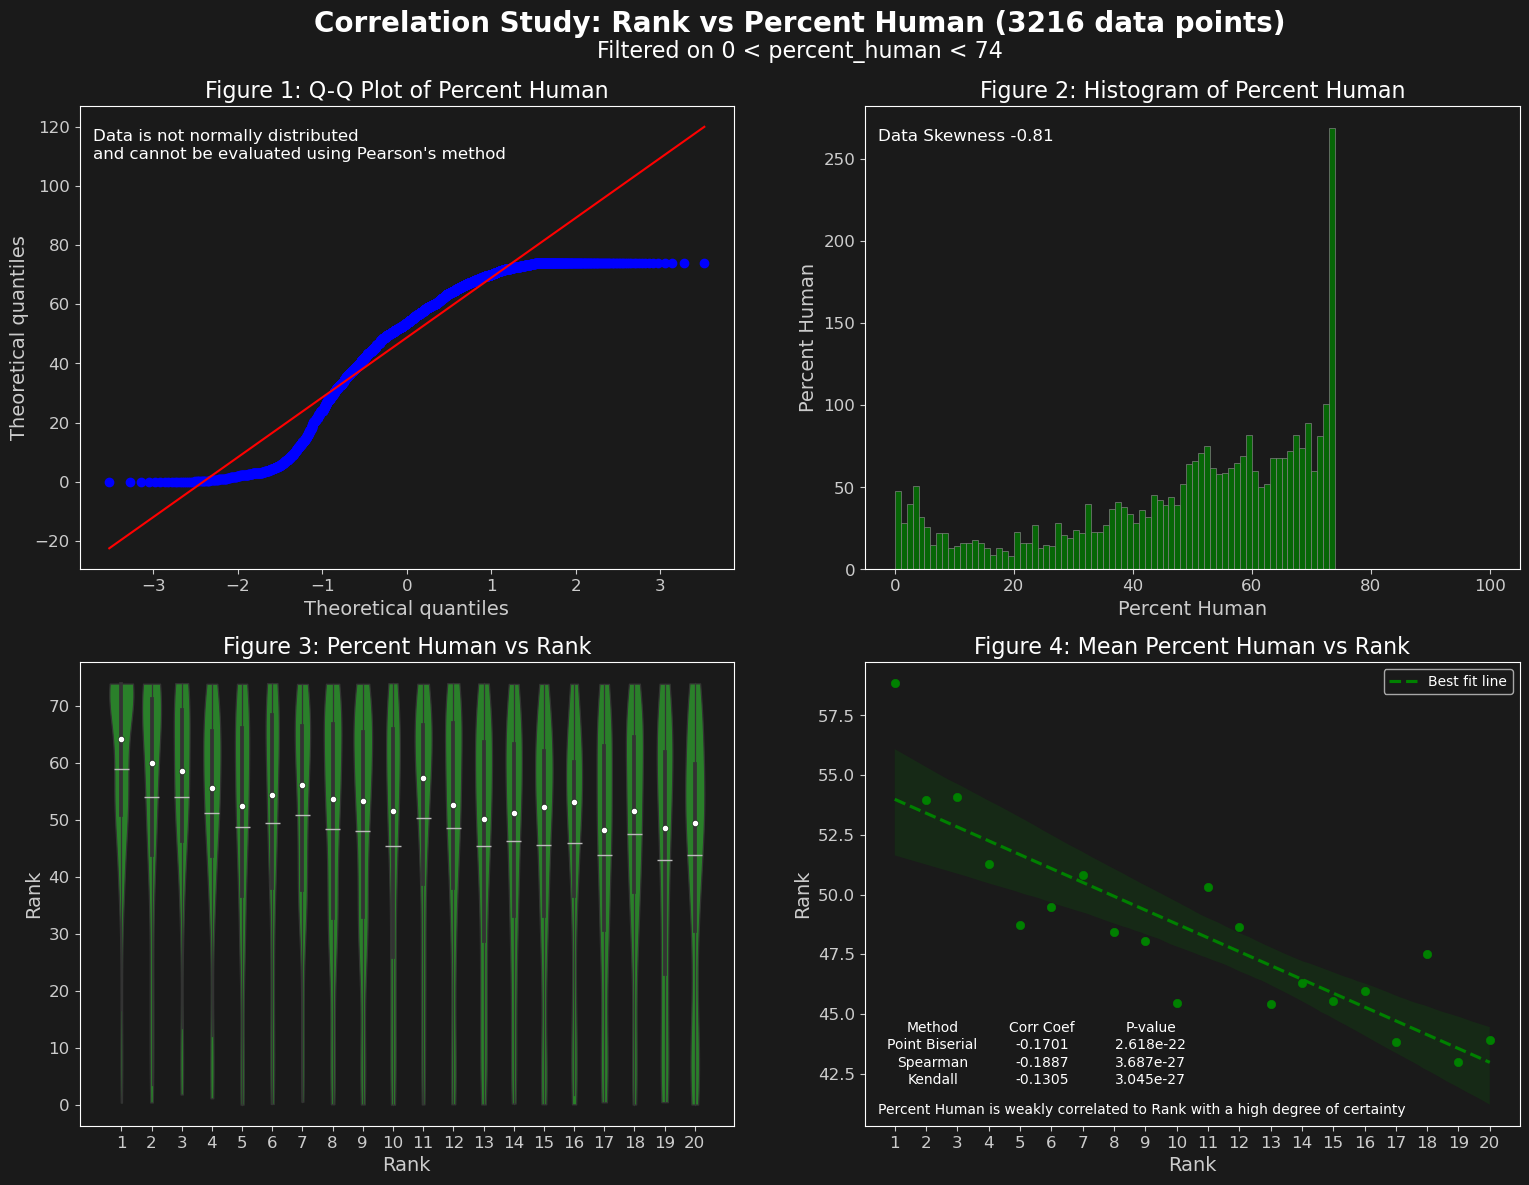

In [556]:
multiplotv_dark(df, 'percent_human', 0, 74)

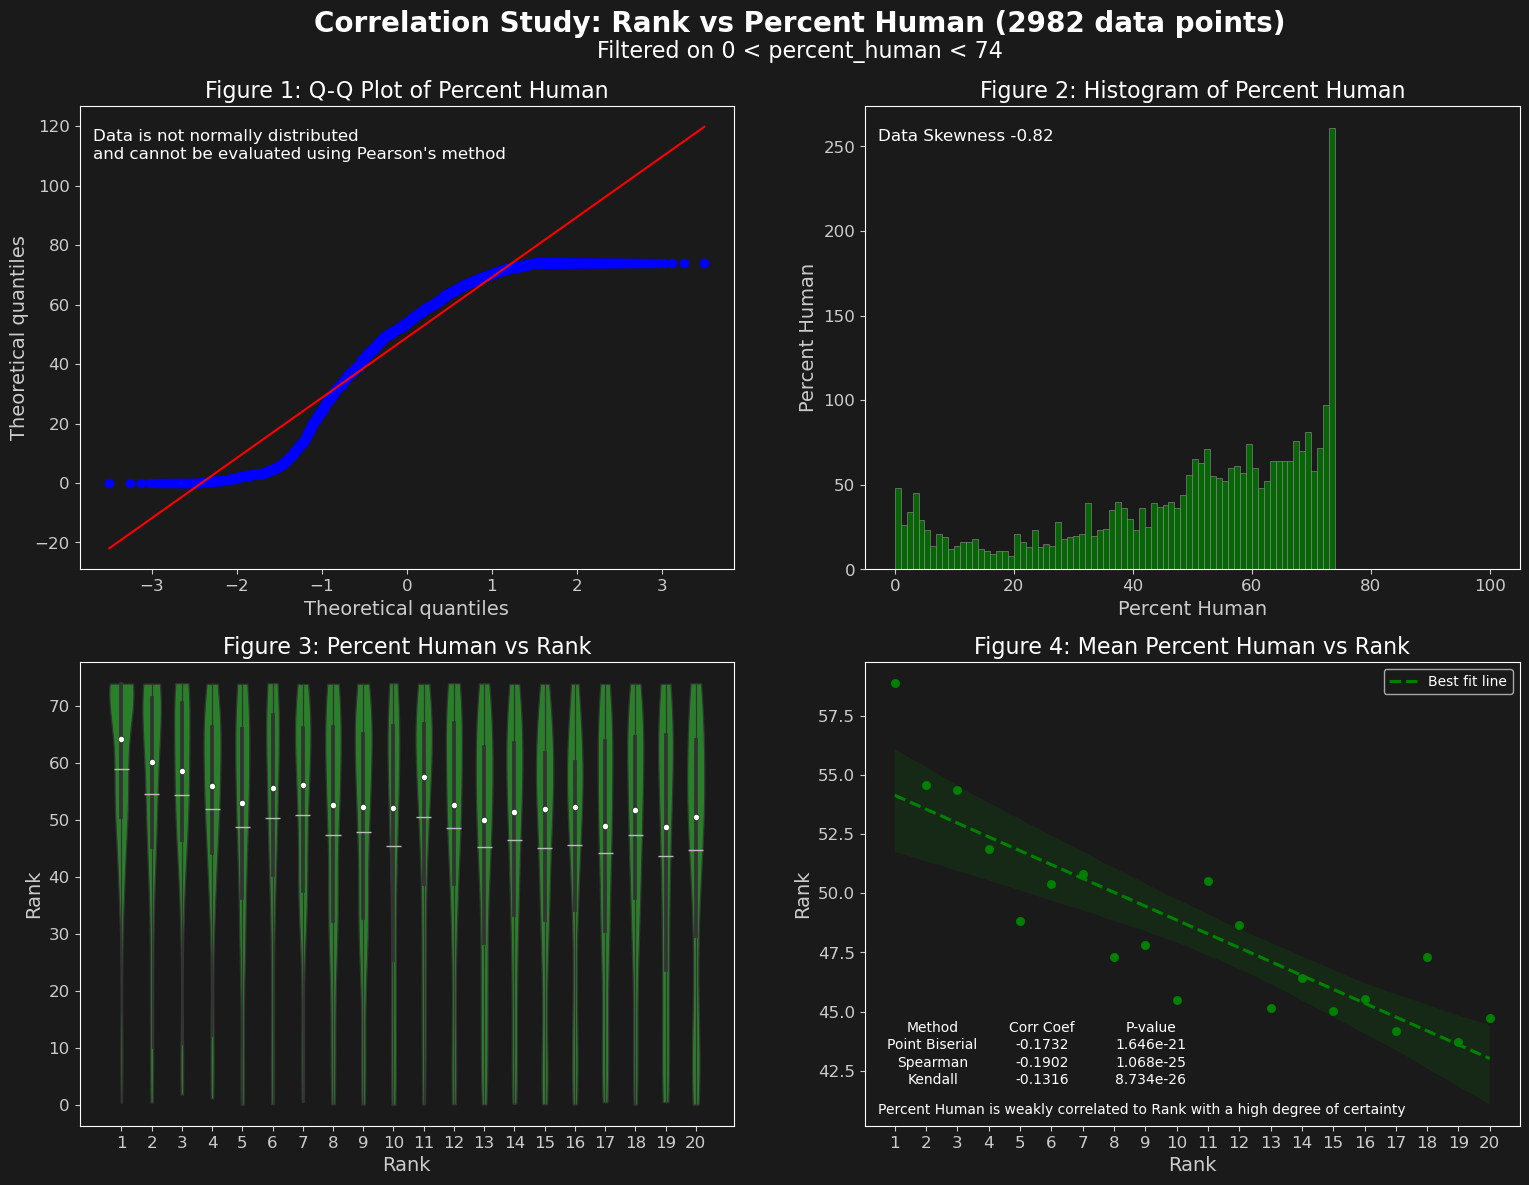

In [557]:
multiplotv_dark(df_unique_links, 'percent_human', 0, 74)

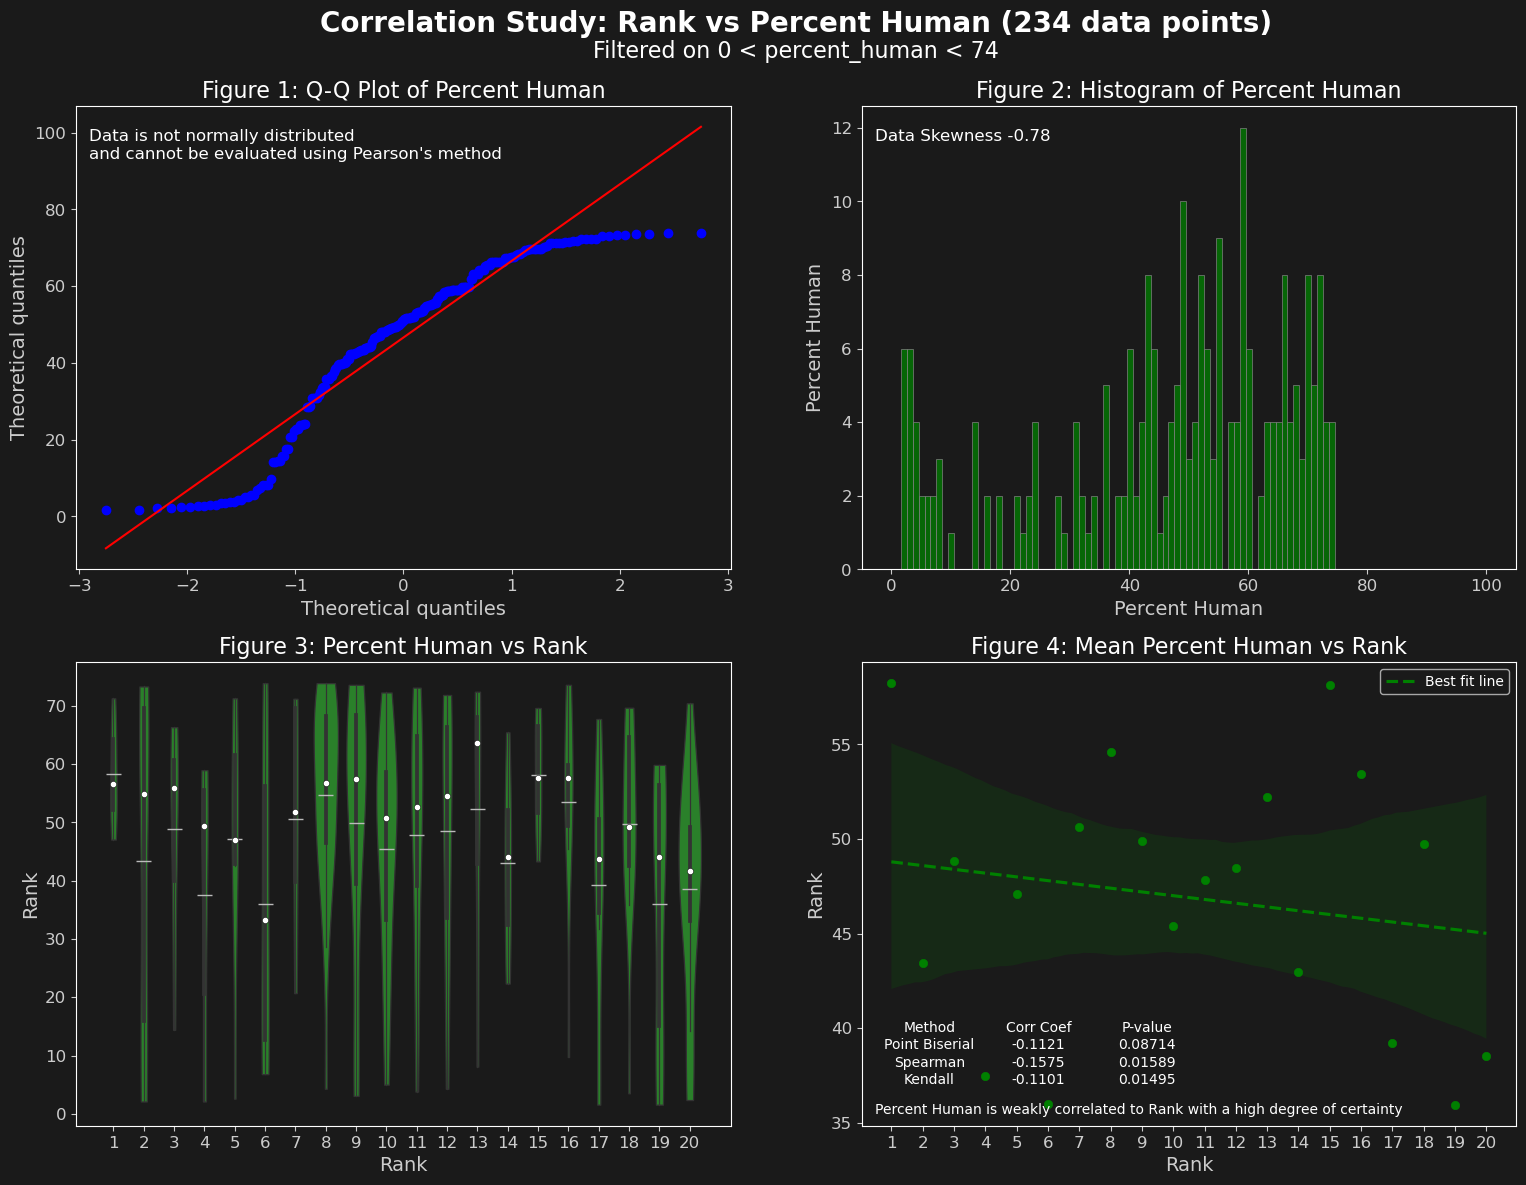

In [558]:
multiplotv_dark(df_nonunique_links, 'percent_human', 0, 74)

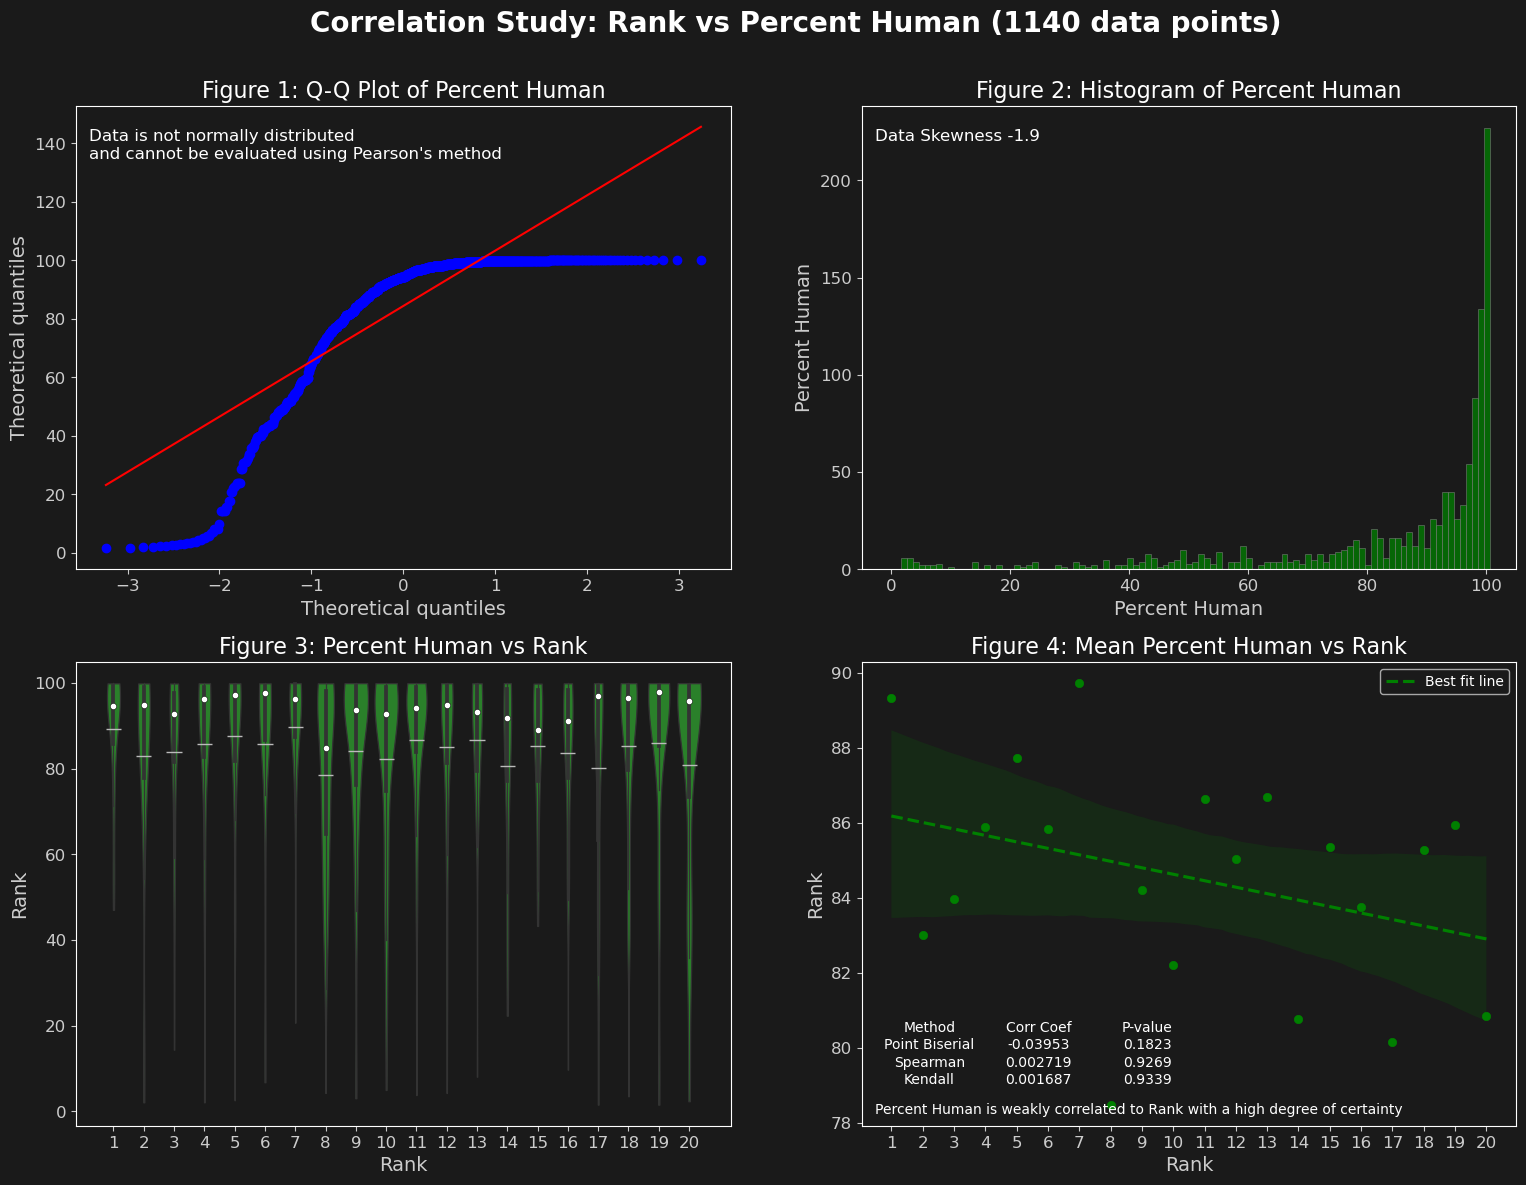

In [559]:
multiplotv_dark(df_nonunique_links)

In [560]:
show_df_info(combined_df)

DataFrame 'combined_df' has 88704 rows and 9 columns.
Here is a summary of the column names, data types and null counts:


,column_name,dtype,non_null_count,null_count
0,kw,object,88704,0
1,SERP features,object,88704,0
2,Volume,int64,88704,0
3,KD,int64,88704,0
4,CPC,float64,88704,0
5,Traffic,int64,88704,0
6,uid,object,88704,0
7,url_count,int64,88704,0
8,link,object,88704,0


In [567]:
show_df_info(df)

DataFrame 'df' has 14637 rows and 8 columns.
Here is a summary of the column names, data types and null counts:


,column_name,dtype,non_null_count,null_count
0,kw,object,14637,0
1,rank,int64,14637,0
2,link,object,14637,0
3,success,bool,14637,0
4,word_count,float64,14637,0
5,percent_human,float64,14637,0
6,percent_ai,float64,14637,0
7,uid,object,14637,0


In [561]:
#for row in df, combined_df:
#    if df['link']==combined_df['link']:
#        print('true')

In [562]:
cdf1 = combined_df[combined_df['link'].isin(df['link'])]
cdf1.head(1)

,kw,SERP features,Volume,KD,CPC,Traffic,uid,url_count,link
0,horny goat weed,Knowledge panel,76000,61,0.37,70591,horny goat weed_https://www.webmd.com/vitamins...,10,https://www.webmd.com/vitamins/ai/ingredientmo...


In [563]:
cdf2 = cdf1[cdf1['kw'].isin(df['kw'])]
len(cdf1)

5828

In [564]:
len(cdf1)

5828

In [565]:
cdf3 = combined_df[combined_df['kw'].isin(df['kw'])]
len(cdf3)

1023

In [566]:
cdf4 = cdf3[cdf3['link'].isin(df['link'])]
len(cdf4)

757

In [569]:
count_unique(df, 'link')

{'https://www.homepest.com/blog/are-wolf-spiders-poisonous': 4,
 'https://www.insider.com/guides/home/how-to-get-rid-of-ants': 3,
 'https://my.clevelandclinic.org/health/diseases/17658-stye': 3,
 'https://www.mayoclinic.org/diseases-conditions/sty/symptoms-causes/syc-20378017': 3,
 'https://nymag.com/strategist/article/best-black-work-pants-for-women.html': 3,
 'https://my.clevelandclinic.org/health/diseases/8718-sleep-apnea': 3,
 'https://www.hopkinsmedicine.org/health/wellness-and-prevention/the-dangers-of-uncontrolled-sleep-apnea': 3,
 'https://www.nhs.uk/conditions/sleep-apnoea/': 3,
 'https://www.sciatica.com/from-the-doc/tips-for-relieving-headaches-caused-by-neck-pain/': 3,
 'https://www.thespruce.com/best-stackable-washers-and-dryers-4158884': 3,
 'https://www.decks.com/how-to/articles/deck-railing-codes': 3,
 'https://grecorailings.com/five-international-building-code-requirements-you-need-to-know-for-handrails/': 3,
 'https://medlineplus.gov/druginfo/meds/a689006.html': 3,
 '

In [570]:
df[df['link']=='https://www.homepest.com/blog/are-wolf-spiders-poisonous']

,kw,rank,link,success,word_count,percent_human,percent_ai,uid
6362,wolf spiders poisonous,8,https://www.homepest.com/blog/are-wolf-spiders...,True,1297.0,63.3,36.7,wolf spiders poisonous_https://www.homepest.co...
6364,wolf spiders poisonous,10,https://www.homepest.com/blog/are-wolf-spiders...,True,1297.0,63.3,36.7,wolf spiders poisonous_https://www.homepest.co...
13854,is a wolf spider poisonous,8,https://www.homepest.com/blog/are-wolf-spiders...,True,1297.0,63.3,36.7,is a wolf spider poisonous_https://www.homepes...
13855,is a wolf spider poisonous,9,https://www.homepest.com/blog/are-wolf-spiders...,True,1297.0,63.3,36.7,is a wolf spider poisonous_https://www.homepes...


In [572]:
print(df[df['link']=='https://www.homepest.com/blog/are-wolf-spiders-poisonous']['link'])

6362     https://www.homepest.com/blog/are-wolf-spiders...
6364     https://www.homepest.com/blog/are-wolf-spiders...
13854    https://www.homepest.com/blog/are-wolf-spiders...
13855    https://www.homepest.com/blog/are-wolf-spiders...
Name: link, dtype: object


In [578]:
combined_df[combined_df['link']=='https://www.homepest.com/blog/are-wolf-spiders-poisonous\n']

,kw,SERP features,Volume,KD,CPC,Traffic,uid,url_count,link


In [576]:
new[new['url']=='https://www.homepest.com/blog/are-wolf-spiders-poisonous']

,kw,SERP features,Volume,KD,CPC,Traffic,url,uid
